In [ ]:
import supervision as sv
from supervision.metrics import MeanAveragePrecision
from rfdetr import RFDETRBase
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Set GPU


In [ ]:
# Path to CSV
result_df_path = "rfdetr_results.csv"

# Checkpoint
checkpoint = "runs/bihar_to_test_bihar/checkpoint_best_total.pth"

# Name of the experiment
experiment = "Bihar to Test Bihar"

# Dataset dir
dataset_dir = "data/bihar_to_test_bihar"


# separate the source and target states from the experiment name
train_region, test_region = experiment.split(" to ")
print(f"Train region: {train_region}, Test region: {test_region}")


Train region: Bihar, Test region: Test Bihar


In [3]:
sv_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_dir}/test",
    annotations_path=f"{dataset_dir}/test/_annotations.coco.json",
)
print(f"Loaded Dataset: {len(sv_dataset)} images")

Loaded Dataset: 687 images


In [4]:
model = RFDETRBase(pretrain_weights=checkpoint)

targets = []
predictions = []

for path, image, annotations in tqdm(sv_dataset):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

print(len(targets), len(predictions))

Loading pretrain weights


num_classes mismatch: pretrain weights has 2 classes, but your model has 90 classes
reinitializing detection head with 2 classes
100%|██████████| 687/687 [00:54<00:00, 12.58it/s]

687 687


## mAP Calculation

In [5]:
## mAP calculation (non-class agnostic)
print (100 * "=")
print("Class-specific mAP")
print (100 * "=")
map_metric = MeanAveragePrecision(class_agnostic=False)
map_result = map_metric.update(predictions, targets).compute()
# map_result.plot()

matched_classes=map_result.matched_classes.tolist()
print(f"Matched classes: {matched_classes}")

# Extract mAP values
mAP_50_95 = map_result.map50_95  # mAP 50:95
mAP_50 = map_result.map50  # mAP 50
mAP_75 = map_result.map75  # mAP 75
print(f"mAP 50:95: {mAP_50_95}, mAP 50: {mAP_50}, mAP 75: {mAP_75}")

# Extract class-wise mAP values
num_classes=3
final_class_wise_mAP = [0]*num_classes
class_wise_mAP=map_result.ap_per_class[:,0].tolist()
for cls, mAP in zip(matched_classes, class_wise_mAP):
    print(f"cls: {cls}, mAP: {mAP}")
    final_class_wise_mAP[cls] = mAP

# Compute class-agnostic mAP
print (100 * "=")
print("Class-agnostic mAP")
print (100 * "=")
mAP_metric_agnostic = MeanAveragePrecision(class_agnostic=True)
mAP_result_agnostic = mAP_metric_agnostic.update(predictions, targets).compute()
# Extract class-agnostic mAP values
mAP_50_95_agnostic = mAP_result_agnostic.map50_95  # mAP 50:95
mAP_50_agnostic = mAP_result_agnostic.map50  # mAP 50
mAP_75_agnostic = mAP_result_agnostic.map75  # mAP 75
print(f"CA mAP 50:95: {mAP_50_95_agnostic}, CA mAP 50: {mAP_50_agnostic}, CA mAP 75: {mAP_75_agnostic}")

Class-specific mAP
Matched classes: [0, 1, 2]
mAP 50:95: 0.09369083469191852, mAP 50: 0.18438685997514226, mAP 75: 0.08624789824874701
cls: 0, mAP: 0.033003300330033
cls: 1, mAP: 0.008246971557560531
cls: 2, mAP: 0.5119103080378332
Class-agnostic mAP
CA mAP 50:95: 0.24885399606250602, CA mAP 50: 0.4976124910959242, CA mAP 75: 0.21273150902377824


In [6]:
columns=["Model","Train", "Test", "Images", "CFCBK", "FCBK", "Zigzag", "Class-agnostic AP"]
result_df = pd.DataFrame(columns=columns)
# new_row = [experiment] + final_class_wise_mAP + [mAP_50_agnostic]
new_row = ["RFDETR", train_region, test_region, len(sv_dataset)] + final_class_wise_mAP + [mAP_50_agnostic]
    
result_df.loc[len(result_df)] = new_row  # Using loc to add the row

# Display DataFrame
display(result_df.style.hide(axis="index"))

Model,Train,Test,Images,CFCBK,FCBK,Zigzag,Class-agnostic AP
RFDETR,Bihar,Test Bihar,687,0.033003,0.008247,0.511910,0.497612


In [7]:
# result_df.to_csv(result_df_path, index=False)

In [8]:
# # Save DataFrame    
# result=pd.read_csv(result_df_path)
# result=result.reset_index(drop=True)
# result = pd.concat([result, result_df], ignore_index=True)
# display(result.style.hide(axis="index"))
# result.to_csv(result_df_path, index=False)

In [9]:
result=pd.read_csv(result_df_path)
display(result.style.hide(axis="index"))

Model,Train,Test,Images,CFCBK,FCBK,Zigzag,Class-agnostic AP
RFDETR,Bihar,Test Bihar,687,0.033003,0.008247,0.511910,0.497612


In [10]:
result=pd.read_csv(result_df_path)
result = result.iloc[:, [1, 2, -1]]
display(result.style.hide(axis="index"))

Train,Test,Class-agnostic AP
Bihar,Test Bihar,0.497612


### Confusion Matrix


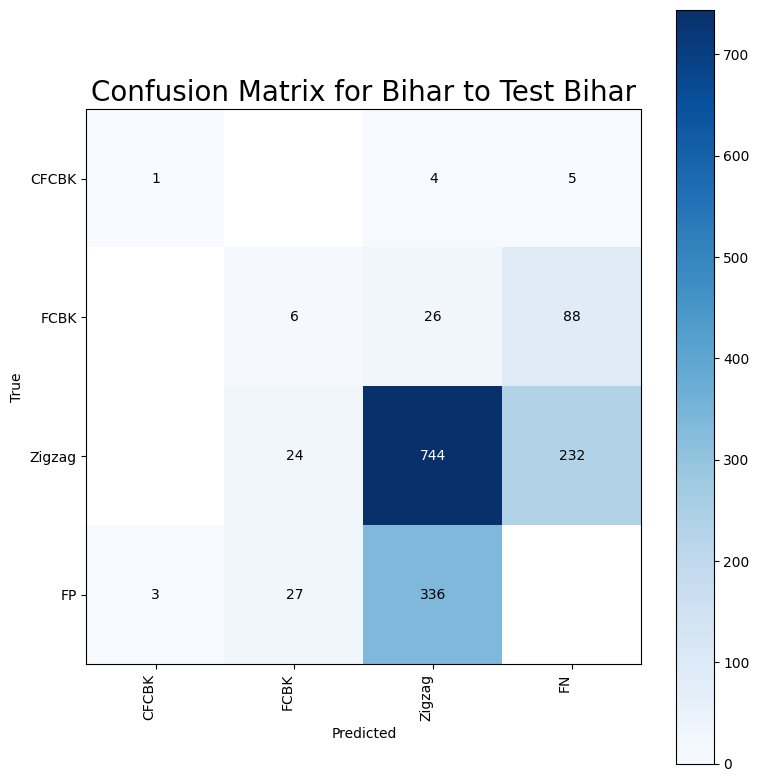

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=sv_dataset.classes,
)

confusion_matrix.plot(
    fig_size=(8,8),
    title=f"Confusion Matrix for {experiment}",
)
plt.show()
plt.close()